In [82]:
# 파이썬 3.7 이상
import sys
assert sys.version_info >= (3, 7)

# 사이킷런 1.0.1 이상
import sklearn
assert sklearn.__version__ >= "1.0.1"

# 랜덤 시드 지정
import numpy as np
np.random.seed(15)

In [83]:
# [ 캘리포니아 주의 구역별 주택 중위가격 예측하는 모델 ]
# ---------- 데이터 다운로드 ------------

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        # parents=True : 필요하면 상위 폴더까지 같이 생성
        # exist_ok=True : 이미 폴더가 존재하더라도 에러 발생시키지 않고 넘어가기
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url,tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [84]:
# 데이터 파악하기
# head() : 데이터프레임에 포함된 처음 5개 샘플 보여줌

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [85]:
# info() : 데이터셋 정보 요약

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [86]:
# 위에서 object 형태인 컬럼은 범주형임 -> ocean_proximity
# value_counts()는 범주형 특성 탐색

housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [87]:
# describe() : 수치형 특성 탐색

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [88]:
# --------- 그래프, 히스토그램 -----------
# 폰트 설정

import matplotlib.pyplot as plt

plt.rc('font', size = 15)
plt.rc('axes', labelsize = 10, titlesize = 20)
plt.rc('legend', fontsize = 10)       # 범례
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)

# 저장 경로 설정

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

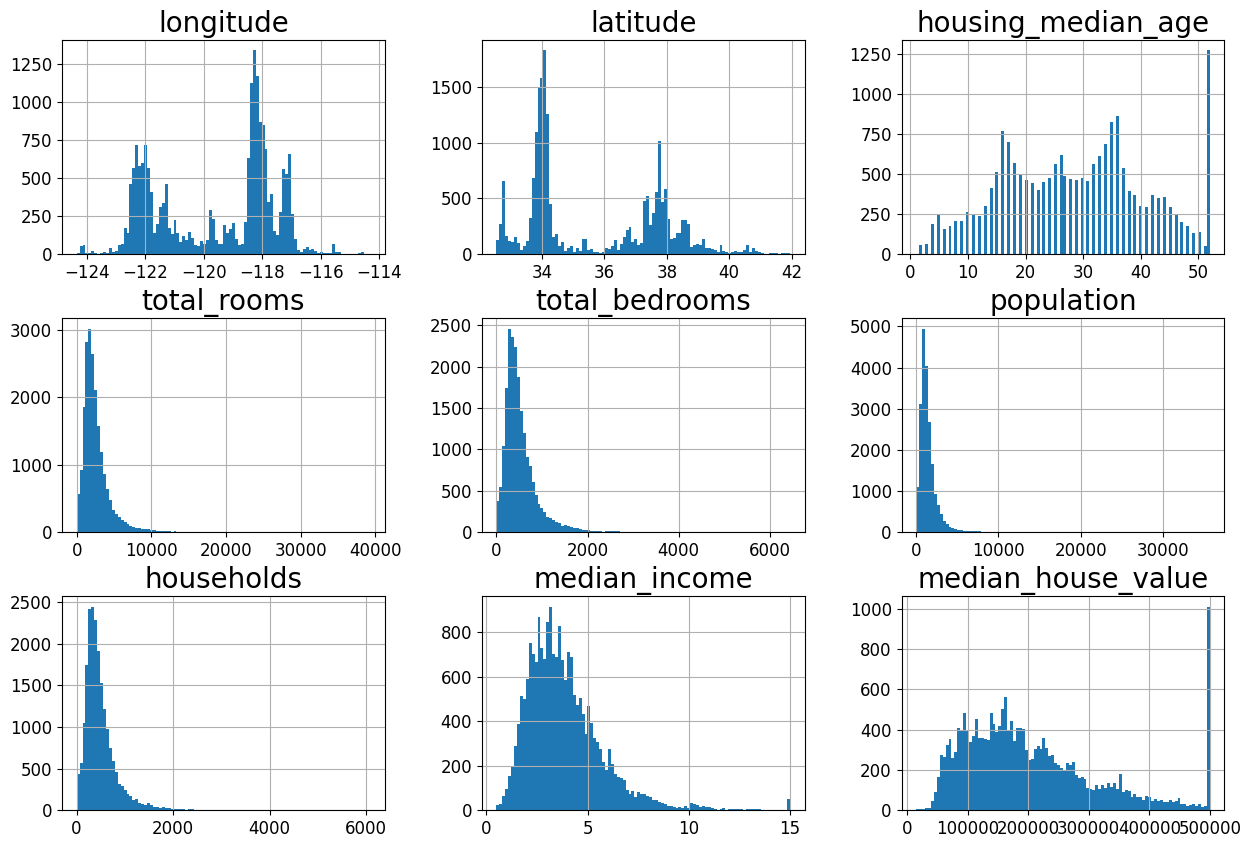

In [89]:
# 수치형 특성 히스토그램
# bins : 구간 개수 (=막대 개수)

housing.hist(bins=100, figsize=(15,10))
plt.show()

In [90]:
# --------- 훈련셋 & 테스트셋 ---------

from sklearn.model_selection import train_test_split
# train,test set 구분하는 함수

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
# -> 랜덤으로 20% 정도 테스트셋 지정하는 방법. 근데 우리는 소득 계층(median_income)을 고려하면서 분류

<Axes: >

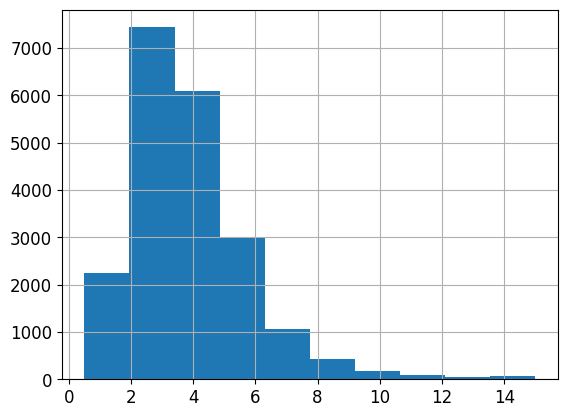

In [91]:
# 계층 샘플링

housing['median_income'].hist()

# 히스토그램 확인 -> 계층 샘플링을 위해 대부분 구역의 중위소득이
# 1.5 ~ 6.0, 즉 15,000 달러에서 60,000 달러 사이라는 사실에 주목하고
#소득 구간을 [0, 1.5, 3.0, 4.6, 6.0, np,inf]로 구분

In [92]:
# 구간 새롭게 나누고 그 소득 구간을 새로운 칼럼(범주형)으로 추가

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins = [0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               # np.inf : 양의 무한대 => 6보다 큰값은 모두 5로 포함
                               labels = [1,2,3,4,5])

housing
# 맨 마지막에 income_cat 칼럼 추가된거 확인할 수 있음

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


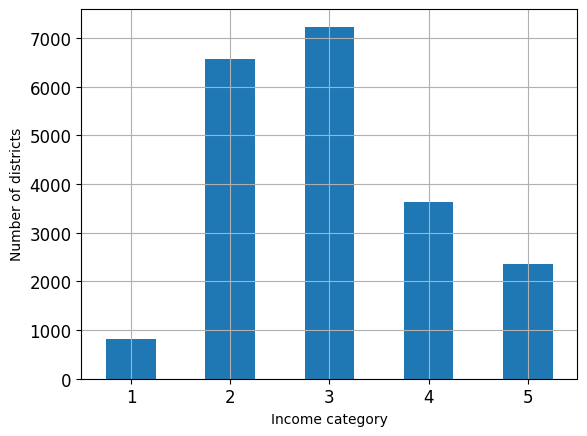

In [93]:
# 소득 구간별 히스토그램 막대그래프로 확인해보기

housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
# rot=0 : x축 라벨 회전 각도 0도
plt.xlabel('Income category')
plt.ylabel('Number of districts')

plt.show()

In [94]:
# 계층 샘플링

start_train_set, start_test_set = train_test_split(
    housing,
    test_size=0.2,
    stratify=housing['income_cat'],   # income_cat을 기준으로 계층 유지되도록 샘플링
    random_state=42
)
# stratify 안쓰고 그냥 무작위 추출하면 구간별 비율이 달라짐

In [95]:
# income_cat은 훈련에는 필요없으니까 삭제

for set_ in (start_train_set, start_test_set):
    set_.drop('income_cat',axis=1, inplace=True)

In [96]:
# ---------- 데이터 시각화 ------------

housing = start_train_set.copy()
# train set 복사해서 사용

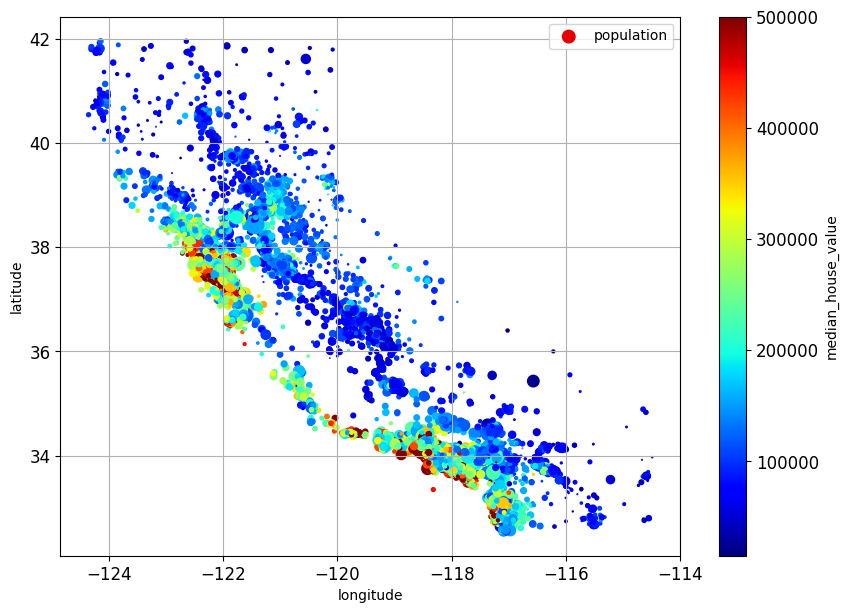

In [97]:
housing.plot(kind='scatter',
             x='longitude', y='latitude',
             grid=True,
             s=housing['population']/100,    # 구역별 인구수에 비례하는 원 크기
             label='population',
             c='median_house_value',         # median house value를 기준으로 색상 지정
             cmap='jet',                     # color map 지정
             colorbar=True,
             legend=True,
             sharex=False,                   #  x-축의 눈금 값과 범례를 표시하지 못하는 버그 수정 용도이며 임시 방편 해결책임
             figsize=(10,7))

plt.show()

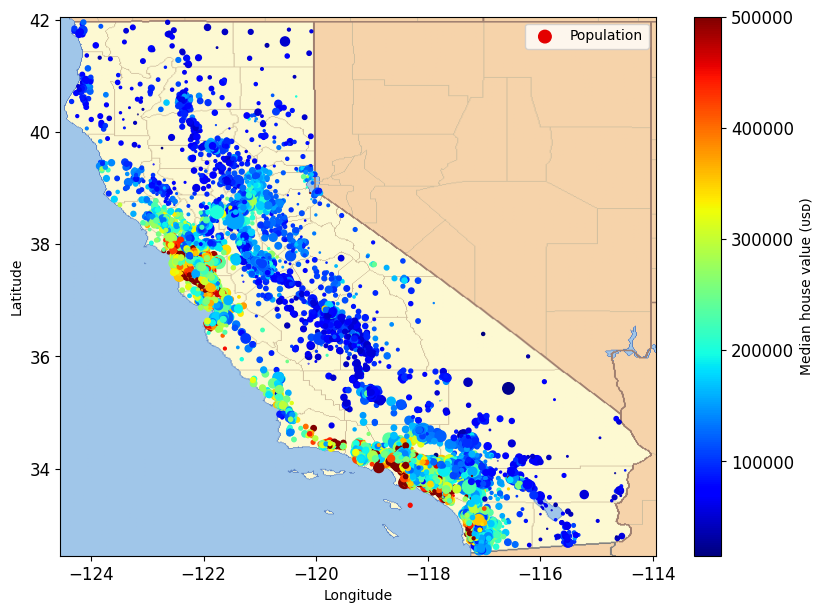

In [98]:
# 캘리포니아 지도 다운로드
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

# 지도에 사용된 특성 이름들 수정
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})

# 위도/경도 이용한 구역별 인구 산포도
housing_renamed.plot(kind="scatter",
                     x="Longitude",
                     y="Latitude",
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Median house value (ᴜsᴅ)",
                     cmap="jet",
                     colorbar=True,
                     legend=True,
                     sharex=False,
                     figsize=(10, 7))


# 다운로드한 지도 -> 산포도랑 합쳐서 함께 그리
california_img = plt.imread( IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05  # x축, y축 눈금
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

In [99]:
# 상관관계

# 계산
corr_matrix = housing.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [100]:
# median_house_value -> 정렬

corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


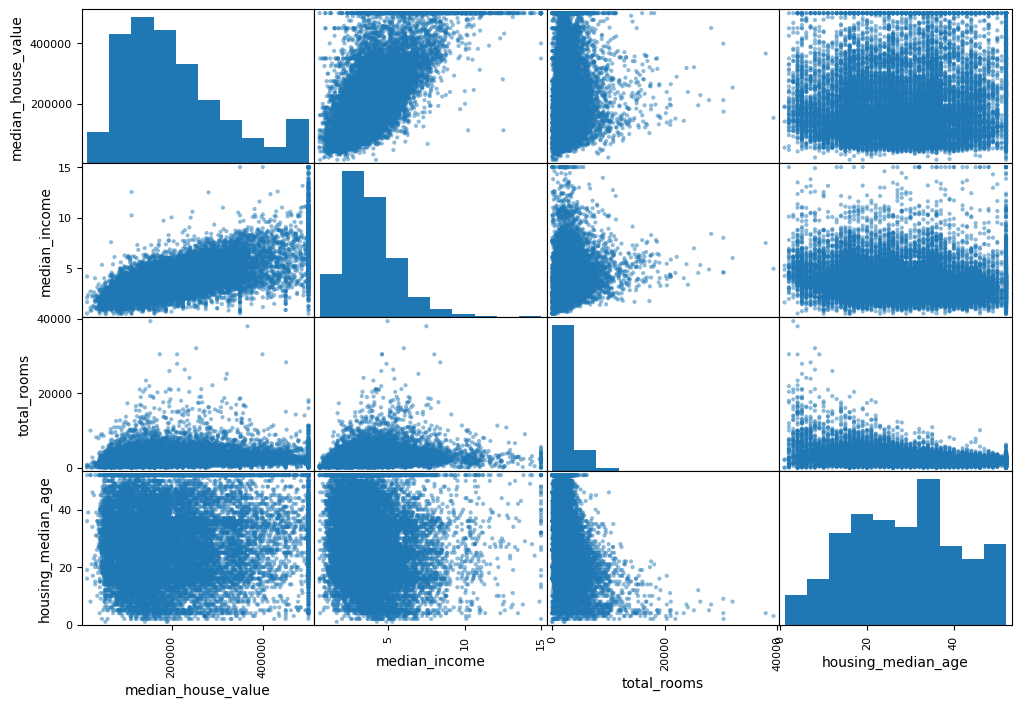

In [101]:
# scatter plot 그려보기

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

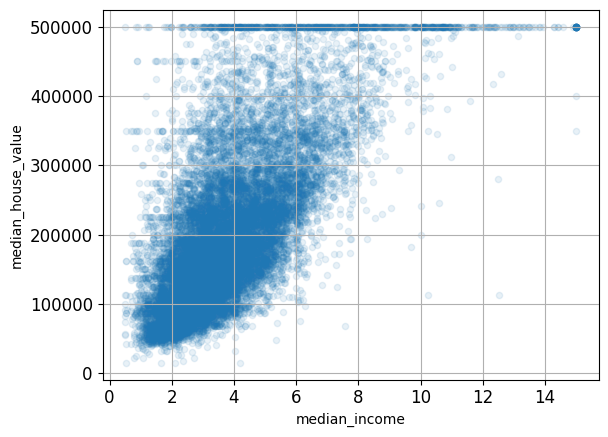

In [102]:
# 중위소득 & 주택 가격 산점도

housing.plot(kind="scatter",
             x="median_income",
             y="median_house_value",
             alpha=0.1,             # 투명도 -> 밀도 높으면 더 진해짐
             grid=True)
plt.show()

In [103]:
# --------- 데이터 정제&전처리 -----------

# 결측치가 있는 샘플의 인덱스 확인
null_rows_idx = housing.isnull().any(axis=1)
null_rows_idx

,0
13096,False
14973,False
3785,False
14689,False
20507,False
...,...
14207,False
13105,False
19301,False
19121,False


In [104]:
# 결측치가 있는 샘플 확인
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,85900.0,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,150400.0,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,161200.0,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,500001.0,<1H OCEAN


In [105]:
housing.loc[null_rows_idx].shape
# 총 168개의 결측치가 존재하는걸 확인할 수 있다

(168, 10)

In [106]:
# 사이킷런 SimpleImputer 변환기 사용 -> 결측치 처리하기

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
# strategy : mean,median, most_frequent, constant 중 선택

housing_num = housing.select_dtypes(include=[np.number])
# 수치형 특성만 중앙값으로 적용

imputer.fit(housing_num)
# fit() : 계산된 결측치 대체값을 변환기 자체의 statistics_ 속성에 저장

imputer.statistics_

array([-1.1851e+02,  3.4260e+01,  2.9000e+01,  2.1250e+03,  4.3400e+02,
        1.1670e+03,  4.0800e+02,  3.5385e+00,  1.7920e+05])

In [107]:
# 결측치 처리. 넘파이 어레이 형태로 봔환됨
import pandas as pd

X = imputer.transform(housing_num)
# 넘파이 어레이 형태로 반환됨
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,85900.0
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,150400.0
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,161200.0
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,410700.0
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,500001.0


In [108]:
# ---------- 입력 데이터셋 & 타깃 데이터셋 -----------

# 입력 데이터셋
housing = start_train_set.drop('median_house_value',axis=1)
# 타깃 데이터셋
housing_labels = start_train_set['median_house_value'].copy()

In [109]:
# ----------- 범주형 특성 전처리 -----------
# ocean_proximity만 범주형이었음

from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[['ocean_proximity']]

cat_encoder = OneHotEncoder(sparse_output=False)
# transform()은 기본적으로 sparse matrix를 반환하기 때문에 dense matrix로 변환
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [110]:
# 변환에 사용된 범주들은 변환기의 categories_ 에 저장됨
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [111]:
# 변환된 특성의 이름들은 feature_names_in_ 에 저장됨
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [112]:
# 변환된 특성들에 대한 각각의 새로운 특성이름은 get_feature_names_out() 으로 확인 가능
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [113]:
# 기본적으로 넘파이 어레이 형태이기 때문에 필요하면 데이터프레임으로 확인하기

housing_cat_onehot = pd.DataFrame(housing_cat_1hot,
                                  columns = cat_encoder.get_feature_names_out(),
                                  index = housing_cat.index
)

housing_cat_onehot

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
14207,1.0,0.0,0.0,0.0,0.0
13105,0.0,1.0,0.0,0.0,0.0
19301,0.0,0.0,0.0,0.0,1.0
19121,1.0,0.0,0.0,0.0,0.0


In [114]:
# --------- 수치형 특성 스케일링 ------------

# 정규화 : min-max 스케일링
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

# 표준화
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [115]:
# ---------- FunctionTransformer 변환기 ------------
from sklearn.preprocessing import FunctionTransformer

# 로그 변환기
log_transformer = FunctionTransformer(np.log, feature_names_out='one-to-one')

# 비율 계산 변환기
log_transformer = FunctionTransformer(lambda X: X[:,[0]] / X[:,[1]])

In [116]:
# --------- 군집 변환기 -------------
# 직접 구현해야 하는 부분

from sklearn.base import BaseEstimator, TransformerMixin
# BaseEstimator,TransformerMixin 클래스는 반드시 상속해야 함
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters          # KMeans에서 군집 수
        self.gamma = gamma                    # RBF 유사도 계산할 때 사용할 하이퍼파라미터
        self.random_state = random_state      # 랜덤 시드

    # 군집화
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans.fit(X, sample_weight=sample_weight)      # sampe_weight : 샘플별로 가중치 적용
        return self     # fit()함수의 반환값은 항상 self

    # 샘플-군집 중심 유사도를 새로운 특성으로 추가
    def transform(self,X):
        return rbf_kernel(X, self.kmeans.cluster_centers_, gamma=self.gamma)

    # transform() 결과로 나오는 row(=군집 유사도)의 이름 자동으로 정해줌
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [117]:
housing['median_income']

,median_income
13096,2.0987
14973,6.0876
3785,2.4330
14689,2.2618
20507,3.5292
...,...
14207,4.7105
13105,2.5733
19301,4.0616
19121,4.1455


In [118]:
# ClusterSimilarity 적용

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=15)

similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']],
                                           sample_weight=housing['median_income'])

In [119]:
# --------- Pipeline ------------
# 수치형 특성 변환 기본 파이프라인
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
    ])

# ColumnTransformer 클래스 : 특성별로 파이프라인 지정 가능
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

# 범주형 파이프라인
from sklearn.pipeline import make_pipeline

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

# 수치형/범주형 구별해서 파이프라인 구성
preprocessing = ColumnTransformer([('num', num_pipeline, num_attribs),
                                   ('cat', cat_pipeline, cat_attribs)
                                   ])

In [120]:
# 정리
# 비율 변환기
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(fuction_transformer, feature_names_in):
    return ['ratio']

ratio_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),
    StandardScaler())

# 로그 변환기
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler())

# 군집 변환기
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

# 기본 변환기
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                     StandardScaler())



In [121]:
# 파이프라인 최종본
from sklearn.compose import make_column_selector

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline, ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline, ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline, ['population','households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population',
                           'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include='object'))
    # make_column_transformer() : 파이프라인 적용할 특성 선택할 수 있
],
remainder=default_num_pipeline)

housing_prepared = preprocessing.fit_transform(housing)

In [122]:
# 정제 & 전처리 결과 확인

housing_prepared.shape
# 총 24개의 특성 가짐

(16512, 24)

In [123]:
preprocessing.get_feature_names_out()
# 24개 특성 이름 확인

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [124]:
# 데이터프레임으로 확인하면?
housing_prepared_df = pd.DataFrame(housing_prepared,
                                   columns=preprocessing.get_feature_names_out(),
                                   index=housing.index)

housing_prepared_df.head()

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,8.708837e-08,9.712456e-01,...,7.114441e-04,3.070969e-17,1.314047e-01,5.740031e-01,0.0,0.0,0.0,1.0,0.0,1.861119
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.181328e-01,9.738096e-14,...,3.045359e-27,5.437838e-01,1.735342e-09,2.275194e-10,1.0,0.0,0.0,0.0,0.0,0.907630
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,2.295286e-08,7.457782e-01,...,4.750719e-03,1.605970e-17,2.744847e-01,2.839978e-01,0.0,1.0,0.0,0.0,0.0,0.351428
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,4.618947e-04,3.873884e-20,...,2.916178e-35,7.405721e-01,2.243339e-14,4.218649e-16,0.0,1.0,0.0,0.0,0.0,-0.919891
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,3.166634e-02,7.905346e-16,...,2.843975e-30,7.501278e-01,2.890866e-11,3.710912e-12,0.0,0.0,0.0,0.0,1.0,0.589800


In [138]:
# ---------- 모델 선택, 훈련 ------------
# 선형 회귀 모델

# 훈련
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

# 예측
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

# 오차값 계산
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print('오차값 : ', error_ratios)

# RMSE 구해보기
from sklearn.metrics import mean_squared_error
import numpy as np

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('RMSE : ', lin_rmse)
# RMSE 높음 => 언더피팅. 모델 적합하지 않음

오차값 :  [-0.47021602 -0.22302604  0.25368732  0.03433923 -0.10281924]
RMSE :  68647.95686706658


In [143]:
# decision tree 모델
# 훈련
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=15))
tree_reg.fit(housing, housing_labels)

# 예측
housing_predictions = tree_reg.predict(housing)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)
# 오버피팅. 의미 없는 모델!

0.0


In [147]:
# 랜덤 포레스트 회귀 모델
# 훈련
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(n_estimators=100, random_state=15))
forest_reg.fit(housing, housing_labels)

17467.85627906477


In [148]:
# 예측
housing_predictions = forest_reg.predict(housing)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

17467.85627906477


In [156]:
# ------------- 교차 검증 -------------
# cross_val_score() 사용하면됨

# decision tree 모델로 예시
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=10)
# 음수 값을 반환하기 때문에 앞에 '-' 써야함

# pandas.Series 사용하면 통계 정보 쉽게 확인 가능
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,66062.497360
std,1549.894826
min,63726.951958
25%,64928.986965
50%,65984.814258
75%,67340.257602
max,68106.850060


In [161]:
# ----------- fine-tuning ------------
# GridSearch or RandomSearch -> 랜덤서치로 연습해봄
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint   # 정수형 하이퍼파라미터 범위 설정

# 하이퍼파라미터 탐색 공간 지정
param_distribs = {'preprocessing__geo_n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

# 하이퍼파라미터 10개 랜덤 선택 + 3-겹 교차 검증
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=15)),
])

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=15)

rnd_search.fit(housing, housing_labels)

ValueError: Invalid parameter 'geo_n_clusters' for estimator ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x795cf187cf40>,
                                                                      func=<function column_ratio...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x795cf1905910>)]). Valid parameters are: ['force_int_remainder_cols', 'n_jobs', 'remainder', 'sparse_threshold', 'transformer_weights', 'transformers', 'verbose', 'verbose_feature_names_out'].

In [162]:
# ----------- fine-tuning ------------
# GridSearch or RandomSearch -> 랜덤서치로 연습해봄
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint   # 정수형 하이퍼파라미터 범위 설정

# 하이퍼파라미터 탐색 공간 지정
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50), # ClusterSimilarity 클래스 하이퍼파라미터: 군집 수
                  'random_forest__max_features': randint(low=2, high=20)}

# 하이퍼파라미터 10개 랜덤 선택 + 3-겹 교차 검증
rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=15))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x795cf17b7390>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x795cf153cd10>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [163]:
rnd_search.best_params_
# 최적의 하이퍼파라미터조합 : 군집 45개, feature 최대 9개

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}

In [166]:
# ----------- 최적 모델 활용 ----------

# 최적의 모델
final_model = rnd_search.best_estimator_

# 피쳐별 상대적 중요도
feature_importances = final_model['random_forest'].feature_importances_

# 피쳐 이름 추가 -> 중요도 기준으로 내림차순 정렬해보면?
sorted(zip(feature_importances,
           final_model['preprocessing'].get_feature_names_out()),
       reverse=True)
# log__median_income이 주택 가격 예측에 가장 중요한 feature임.

[(np.float64(0.18411849287265464), 'log__median_income'),
 (np.float64(0.06925804573567693), 'bedrooms__ratio'),
 (np.float64(0.06809942440172216), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.05470341263769134), 'rooms_per_house__ratio'),
 (np.float64(0.04687177104801823), 'people_per_house__ratio'),
 (np.float64(0.03894527701017012), 'geo__Cluster 3 similarity'),
 (np.float64(0.02706073112115261), 'geo__Cluster 18 similarity'),
 (np.float64(0.02634024122785791), 'geo__Cluster 22 similarity'),
 (np.float64(0.02168238591751611), 'geo__Cluster 6 similarity'),
 (np.float64(0.021677503033512516), 'geo__Cluster 17 similarity'),
 (np.float64(0.019849041759655545), 'geo__Cluster 35 similarity'),
 (np.float64(0.019346160829906353), 'geo__Cluster 40 similarity'),
 (np.float64(0.01826955217017394), 'geo__Cluster 41 similarity'),
 (np.float64(0.0162552593389485), 'geo__Cluster 31 similarity'),
 (np.float64(0.013911834462689714), 'geo__Cluster 38 similarity'),
 (np.float64(0.013884498726204085)

In [168]:
# 테스트셋 활용 최종 평가
X_test = start_test_set.drop("median_house_value", axis=1)
y_test = start_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

41398.929707905816


In [169]:
# ---------- 최적 모델 저장 & 활용 ------------
import joblib      # 모델 이름 지정 + 저장

joblib.dump(final_model, 'my_california_housing_model.pkl')

['my_california_housing_model.pkl']

In [173]:
final_model_reloaded = joblib.load('my_california_housing_model.pkl')
# 주의할 점 : joblib.load() 사용할 때는 정의했던 함수, 클래스 모두 불러와야함
# 지금은 위에서 다 돌렸기 때문에 오류 안나는거

In [175]:
new_data = housing.iloc[:5]  # 새로운 데이터라고 가정

# 불러온 모델 이용해서 예측할 때 predict() 사용
predictions = final_model_reloaded.predict(new_data)
predictions

array([440588.14, 456546.08, 105189.  , 103387.  , 346877.06])